## 0 - Import pakietów

In [89]:
import pandas as pd
import numpy as np
import re

from sklearn.ensemble import RandomForestClassifier
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bordo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---
## 1 - Pobranie danych

Dane umieszczone w lokalnych folderach projektu, a dokładniej w folderze `dane`.

In [3]:
train_df = pd.read_csv('data/train.csv', header=None, names=['opinion', 'title', 'description'])

In [4]:
test_df = pd.read_csv('data/test.csv', header=None, names=['opinion', 'title', 'description'])

Wyświetlenie pierwszych wierszy obu zbiorów danych:

In [5]:
train_df.head()

,opinion,title,description
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [6]:
test_df.head()

,opinion,title,description
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


Stworzenie obiektu posiadającego odniesienia do całego zbioru danych. Modyfikacje na nim obejmą modyfikację na pobranych zbiorach treninigowych i testowych.

In [96]:
full_df = pd.concat([train_df, test_df])
full_df.shape

(4000000, 3)

In [8]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   opinion      int64 
 1   title        object
 2   description  object
dtypes: int64(1), object(2)
memory usage: 122.1+ MB


---
## 2 - Czyszczenie danych

Sprawdzenie, czy dane zwierają puste atrybyuty:

In [9]:
print(full_df.isna().sum())

opinion          0
title          231
description      0
dtype: int64


Występują puste atrybuty w kolumnie *title*. W celu obsłużenia pustych danych, pozbywam się wszystkich kolumn, które takie dane zawierają oraz wyświetlam wynik:

In [10]:
full_df.dropna(inplace=True)
print(full_df.isna().sum())

opinion        0
title          0
description    0
dtype: int64


---
## 3 - Przetwarzanie wstępne

In [37]:
def split_into_equal_parts(df, random_state=42):
    # Pierwszy podział: na 2 połowy
    part1, part2 = train_test_split(df, test_size=0.5, random_state=random_state)
    # Drugi podział: rozbicie każdej połowy na 2 kolejne części
    part1a, part1b = train_test_split(part1, test_size=0.5, random_state=random_state)
    part2a, part2b = train_test_split(part2, test_size=0.5, random_state=random_state)
    return part1a, part1b, part2a, part2b

In [39]:
train_parts = split_into_equal_parts(train_df, random_state=42)

test_parts = split_into_equal_parts(test_df, random_state=42)

full_parts = [pd.concat([train_part, test_part], ignore_index=True) for train_part, test_part in zip(train_parts, test_parts)]

In [66]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def to_lowercase_and_remove_punctuation(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def tokenize_text(text):
    if isinstance(text, str):
        return nltk.word_tokenize(text)
    else:
        return text

def remove_stopwords(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stop_words]
    else:
        return tokens

def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    else:
        return tokens

In [69]:
curr_df = full_parts[0].iloc[:100000, :].copy()

curr_df['Cleaned_Review'] = curr_df['description'].apply(to_lowercase_and_remove_punctuation)

curr_df['Tokenized_Review'] = curr_df['Cleaned_Review'].apply(tokenize_text)

curr_df['Stemmed_Review'] = curr_df['Tokenized_Review'].apply(stem_tokens)

curr_df['No_Stopwords_Review'] = curr_df['Tokenized_Review'].apply(remove_stopwords)

In [83]:
curr_df.head()

,opinion,title,description,Cleaned_Review,Tokenized_Review,No_Stopwords_Review,Stemmed_Review
0,2,"Excellent book, bad typographical expression",A practical book on important topics to make m...,a practical book on important topics to make m...,"[a, practical, book, on, important, topics, to...","[practical, book, important, topics, make, mon...","[a, practic, book, on, import, topic, to, make..."
1,1,Don't see this movie,I rented this movie based on reviews that stat...,i rented this movie based on reviews that stat...,"[i, rented, this, movie, based, on, reviews, t...","[rented, movie, based, reviews, stated, though...","[i, rent, thi, movi, base, on, review, that, s..."
2,2,a delightful read,"after watching the late news, I pick up A Cast...",after watching the late news i pick up a castl...,"[after, watching, the, late, news, i, pick, up...","[watching, late, news, pick, castle, backyard,...","[after, watch, the, late, news, i, pick, up, a..."
3,2,Dysfunctional family at it's best,This family that the movie is about is so outl...,this family that the movie is about is so outl...,"[this, family, that, the, movie, is, about, is...","[family, movie, outlandishly, dysfunctional, f...","[thi, famili, that, the, movi, is, about, is, ..."
4,1,unbelievable set-up,The KNEX company has written incredibly poor i...,the knex company has written incredibly poor i...,"[the, knex, company, has, written, incredibly,...","[knex, company, written, incredibly, poor, ins...","[the, knex, compani, ha, written, incred, poor..."


## 4 - Analiza eksploracyjna

Procentowy udział opinii pozytywnych i negatywnych

C:\Users\bordo\AppData\Local\Temp\ipykernel_9364\1435735200.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=opinion_counts.index, y=opinion_counts.values, palette='Set2')


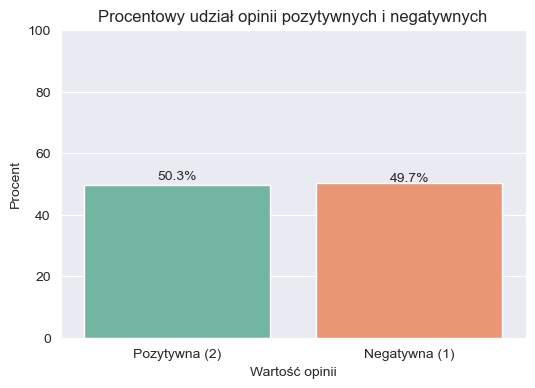

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

opinion_counts = curr_df['opinion'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=opinion_counts.index, y=opinion_counts.values, palette='Set2')

for i, percentage in enumerate(opinion_counts.values):
    ax.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=10)

plt.title('Procentowy udział opinii pozytywnych i negatywnych')
plt.xlabel('Wartość opinii')
plt.ylabel('Procent')
plt.xticks(ticks=[0, 1], labels=['Pozytywna (2)', 'Negatywna (1)'])
plt.ylim(0, 100)
plt.show()


Wykresy pokazujące ilość wystąpień poszczególnych słów w opiniach. Wykresy przedstawiają wystąpienia słów jedynie po tokenizacji oraz po pełnym przetwrzaniu z podziałem na sentyment.

C:\Users\bordo\AppData\Local\Temp\ipykernel_9364\3297964861.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(tokens), palette='husl')


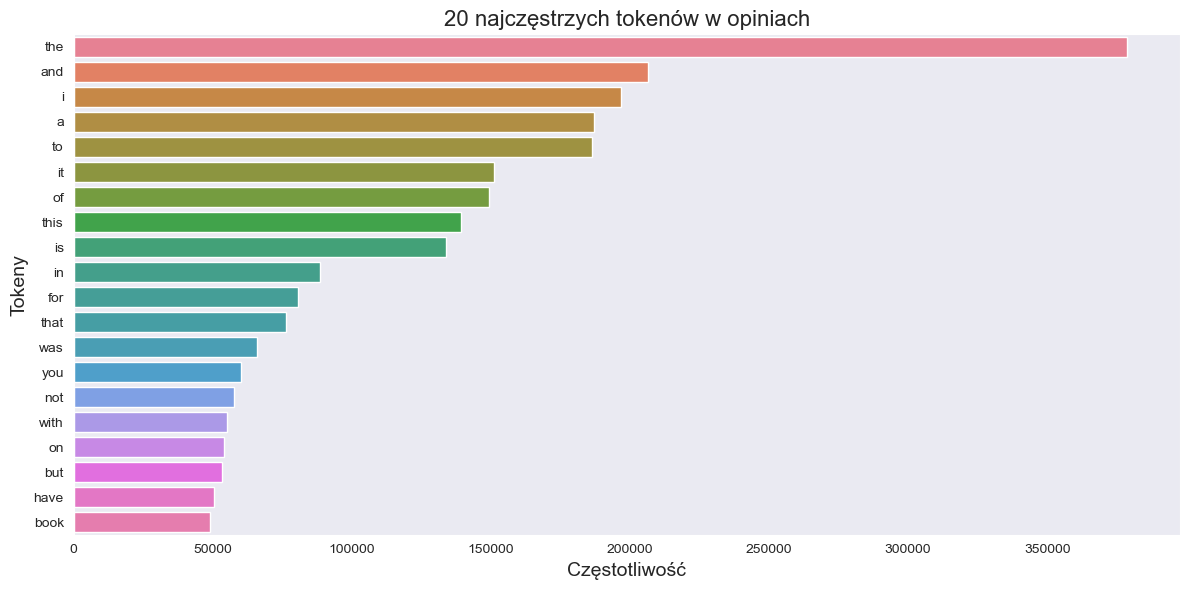

C:\Users\bordo\AppData\Local\Temp\ipykernel_9364\3297964861.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


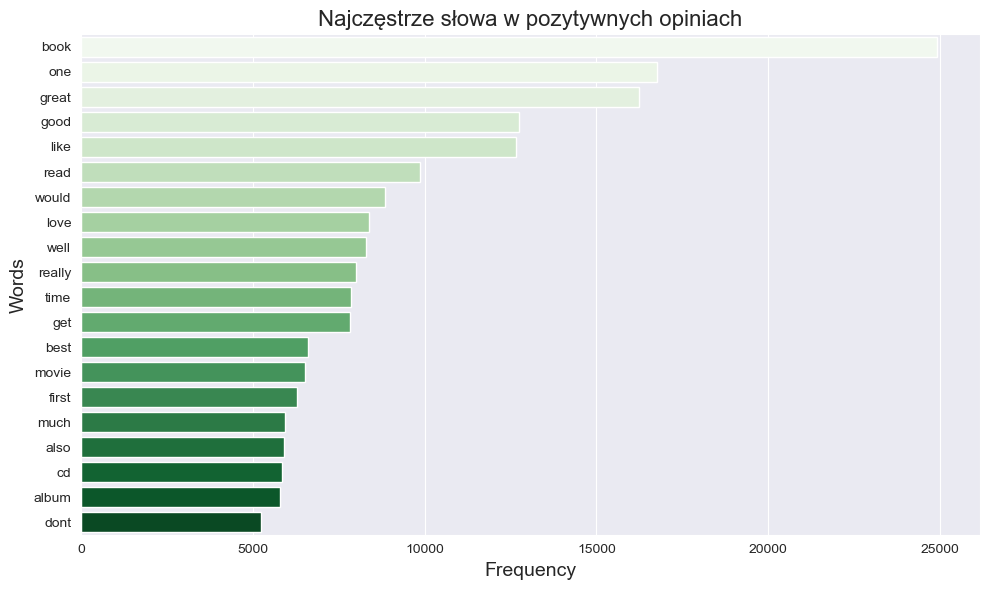

C:\Users\bordo\AppData\Local\Temp\ipykernel_9364\3297964861.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


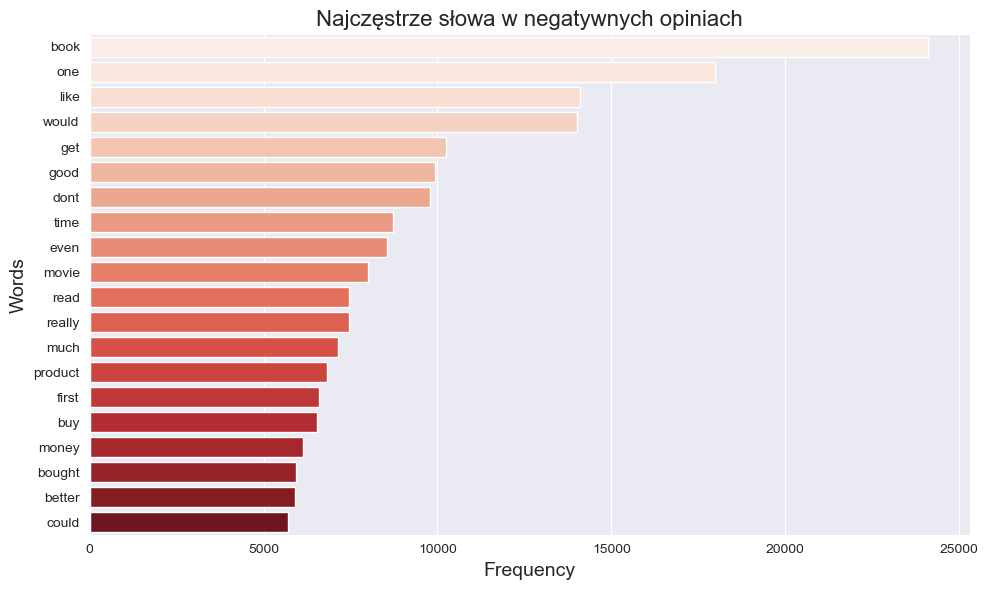

In [76]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Najczęściej występujące słowa w całym zbiorze danych

all_tokens = [token for tokens in curr_df['Tokenized_Review'] for token in tokens]

token_counts = Counter(all_tokens)

common_tokens = token_counts.most_common(20)

tokens, frequencies = zip(*common_tokens)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(frequencies), y=list(tokens), palette='husl')
plt.title('20 najczęstrzych tokenów w opiniach', fontsize=16)
plt.xlabel('Częstotliwość', fontsize=14)
plt.ylabel('Tokeny', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(False)
plt.show()


# Najczęstsze słowa dla pozytywnych i negatywnych recenzji

def plot_most_common_words(common_words, sentiment, color):
    words, counts = zip(*common_words)  # Rozpakowanie słów i ich zliczeń
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette=color)
    plt.title(f'Najczęstrze słowa w {sentiment} opiniach', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.tight_layout()
    plt.show()


positive_reviews = curr_df[curr_df['opinion'] == 2]['No_Stopwords_Review']
negative_reviews = curr_df[curr_df['opinion'] == 1]['No_Stopwords_Review']

positive_words_list = [word for review in positive_reviews for word in review]
negative_words_list = [word for review in negative_reviews for word in review]

positive_words = Counter(positive_words_list).most_common(20)
negative_words = Counter(negative_words_list).most_common(20)

plot_most_common_words(positive_words, 'pozytywnych', 'Greens')
plot_most_common_words(negative_words, 'negatywnych', 'Reds')

Chmury wyrazowe, taka sama konwencja jak poporzednio

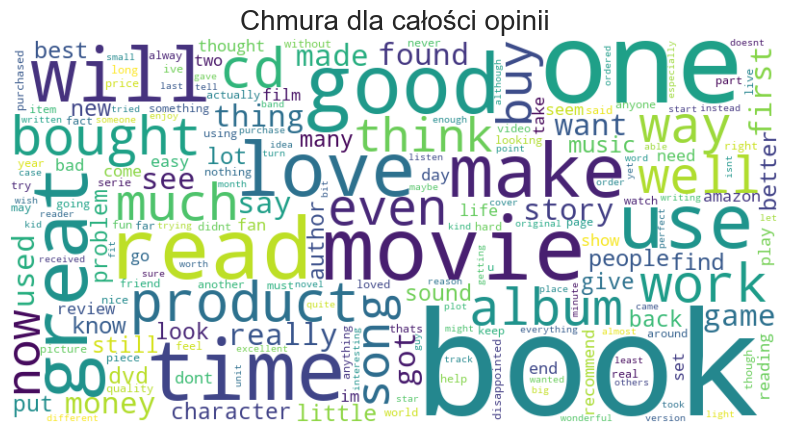

In [87]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400,
                      background_color='white', max_font_size=150).generate(' '.join(curr_df['Cleaned_Review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura dla całości opinii", fontsize=20)
plt.show()

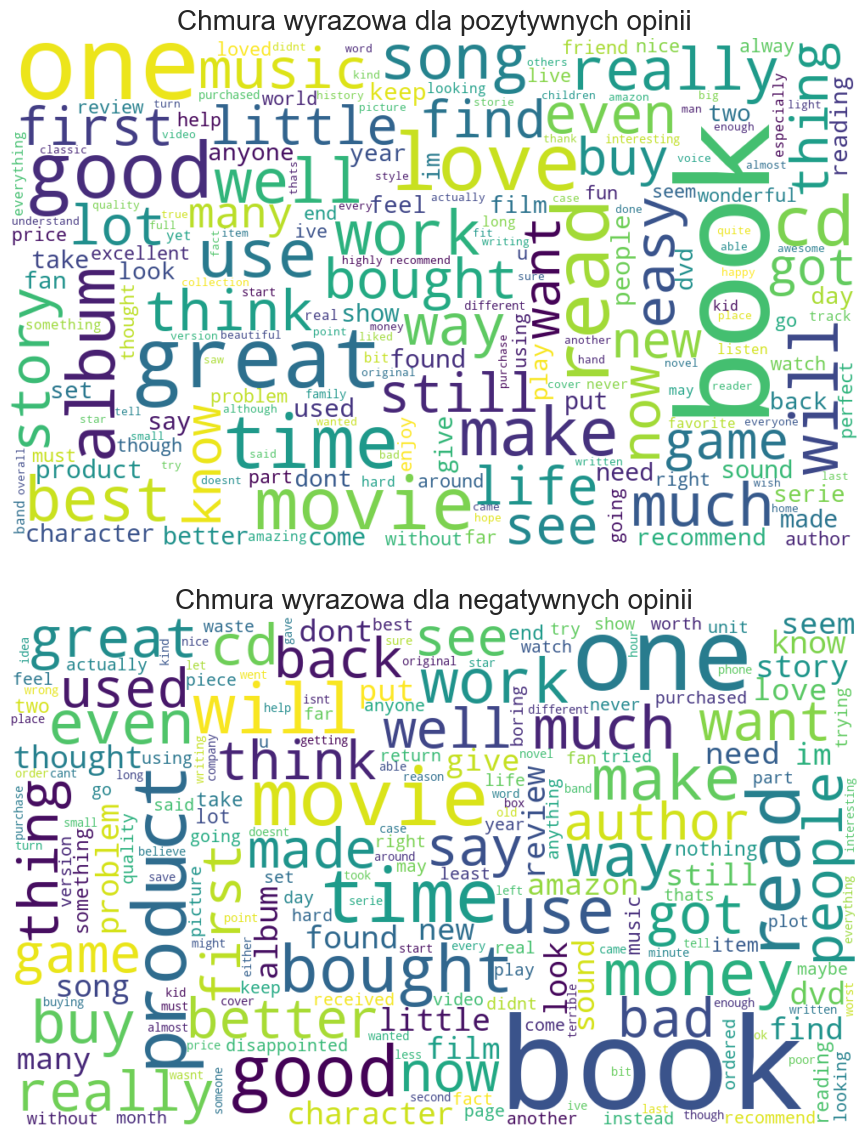

In [85]:
positive_reviews = " ".join(curr_df[curr_df['opinion'] == 2]['Cleaned_Review'].tolist())
negative_reviews = " ".join(curr_df[curr_df['opinion'] == 1]['Cleaned_Review'].tolist())

wordcloud_positive = WordCloud(width=1000, height=600, background_color='white', max_font_size=150).generate(positive_reviews)
wordcloud_negative = WordCloud(width=1000, height=600, background_color='white', max_font_size=150).generate(negative_reviews)

plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Chmura wyrazowa dla pozytywnych opinii', fontsize=20)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Chmura wyrazowa dla negatywnych opinii', fontsize=20)
plt.axis('off')

plt.tight_layout(pad=3)
plt.show()

# 5 - TF-IDF

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X = tfidf_vectorizer.fit_transform(curr_df['Cleaned_Review'])
y = curr_df['opinion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6 - Modele

Funkcje do rysowania wykresów pozwalajacych na analizę wyników.

In [94]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Macierz pomyłek dla klasyfikatora {model_name}', fontsize=14)
    plt.xlabel('Wartości predykcji')
    plt.ylabel('Wartości faktyczne')
    plt.show()


def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=2)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc:.2f})', color='blue', lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Krzywa ROC dla modelu {model_name}')
    plt.legend(loc="lower right")
    plt.show()

Analiza działania dwóch wybranych modeli: K-najbliższych sąsiadów i lasu losowego.

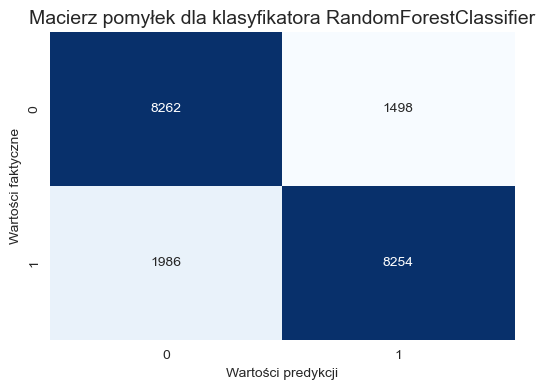

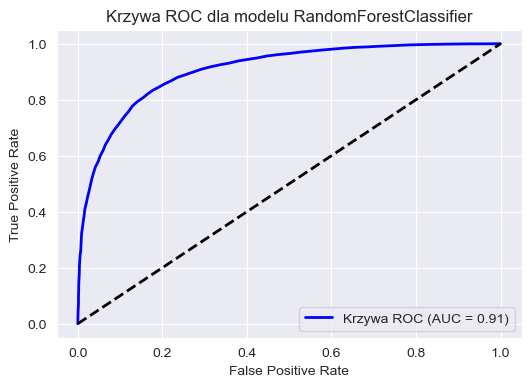

Model 1: RandomForestClassifier
Dokładność na zbiorze treningopwym: 1.0000
Dokładność na zbiorze testowym: 0.8258
-----------------


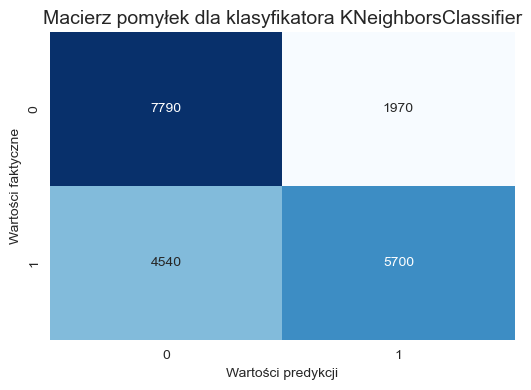

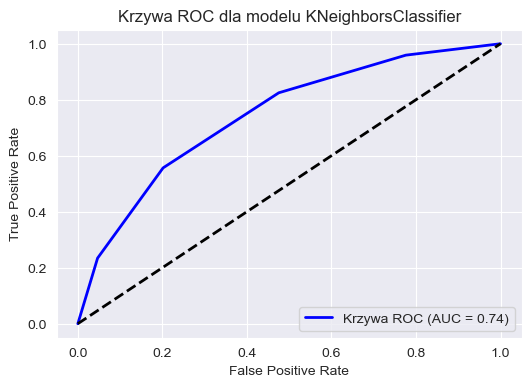

Model 2: KNeighborsClassifier
Dokładność na zbiorze treningopwym: 0.8039
Dokładność na zbiorze testowym: 0.6745
-----------------


In [95]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    plot_confusion_matrix(y_test, y_test_pred, type(model).__name__)

    if len(set(y)) == 2:
        y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_test_pred
        plot_roc_curve(y_test, y_test_prob, type(model).__name__)

    print(f"Model {i+1}: {type(model).__name__}")
    print(f"Dokładność na zbiorze treningopwym: {train_accuracy:.4f}")
    print(f"Dokładność na zbiorze testowym: {test_accuracy:.4f}")
    print("-----------------")